
**Install requirements**

In [ ]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm' 

**Import libraries**

In [ ]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
import torchvision.models as models

from PIL import Image
from tqdm import tqdm

import copy
import pandas as pd

# Visualizations
import matplotlib.pyplot as plt




[4, 5, 6, [1], [2], [3]]


**Set Arguments**

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101    # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 128
#BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate (di quanto mi sposto nella curva. LR piccolo->sposto molto)
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default 

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [ ]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalizes tensor with mean and standard deviation of ImageNet
                                      #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                                                         
])

# Define transforms for training set ONLY.
augmentation_transform = transforms.Compose([transforms.Resize(256),
                                              transforms.CenterCrop(224),
                                              #transforms.RandomRotation(degrees=15),
                                              #transforms.ColorJitter(),
                                              transforms.Grayscale(num_output_channels=3),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                 
])


**Prepare Dataset**

In [ ]:
#import shutil
#shutil.rmtree('./Caltech101', ignore_errors=True)

# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/lindaludovisi/ellelle.git
  !mv 'ellelle' 'Caltech101'


DATA_DIR = 'Caltech101/101_ObjectCategories' #ObjectCategories is the directory containing all images
from Caltech101.caltech_dataset import Caltech #Caltech is a class in caltech_dataset.py


# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)


#Create a list of all the indexes of the original train dataset
original_indexes=list(range(len(train_dataset)))

train_indexes = []
val_indexes = []
#Divide train dataset into train/val
#The idea here is to assign indexes divisible by 2 to val_dataset and the others to train_dataset
#The proportion between categories is maintained because the dataset is sorted by alphabetical order
for index in original_indexes:
  if ( (index %2) == 0) :  
    val_indexes.append(index)
  else:                    
    train_indexes.append(index)

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)

#Perform data augmentation for train_dataset
#train_dataset.dataset.transform = augmentation_transform

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))



length of indexes is:
5784
length of labels is:
5784
length of indexes is:
2893
length of labels is:
2893
Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


**Prepare Dataloaders**

In [ ]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)



**Prepare Network**

In [ ]:
#A useful function that sets the parameters of the model to be updated in training phase.
#When we are finetuning we can leave all of the .requires_grad’s set to the default of True.
def set_parameter_requires_grad(model, feature_extracting):
  
  if feature_extracting == 'conv':  #Freeze conv layers
    for name, param in model.named_parameters(): 
      if 'features' in name :
        param.requires_grad = False
  
  elif feature_extracting == 'fc':  #Freeze fc layers
    for name, param in model.named_parameters(): 
      if 'classifier' in name :
        param.requires_grad = False
        print(name)
      
  else:
    return True


def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
  # Initialize these variables which will be set in this if statement. Each of these
  # variables is model specific.
  model_ft = None
  input_size = 0

  if model_name == "vgg":
    """ VGG11_bn
    """
    model_ft = models.vgg11_bn(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[6].in_features  
    model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
    input_size = 224

  elif model_name == "alexnet":
    """ Alexnet
    """
    model_ft = models.alexnet(pretrained=use_pretrained)  
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)  # nn.Linear in pytorch is a fully connected layer
                                                              # The convolutional layer is nn.Conv2d
    set_parameter_requires_grad(model_ft, feature_extract) 
    input_size = 224 

  return model_ft, input_size


# Loading AlexNet model (not pre-trained)
#net, input_size = initialize_model("alexnet", NUM_CLASSES, False, use_pretrained=False)

# Loading AlexNet pre-trained model
#net, input_size = initialize_model("alexnet", NUM_CLASSES, feature_extract=False, use_pretrained=True)

# Loading AlexNet pre-trained model, freezing conv layers
#net, input_size = initialize_model("alexnet", NUM_CLASSES, feature_extract='conv', use_pretrained=True)

# Loading AlexNet pre-trained model, freezing fc layers
#net, input_size = initialize_model("alexnet", NUM_CLASSES, feature_extract='fc', use_pretrained=True)

# Loading VGG pre-trained model, freezing conv layers
net, input_size = initialize_model("vgg", NUM_CLASSES, feature_extract='conv', use_pretrained=True)


# Print the model we just instantiated
print(net)



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

**Prepare Training**

In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy


# Choose parameters to optimize
 
#parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

parameters_to_optimize = []
print("Params to learn:")
for name, param in net.named_parameters():
  if param.requires_grad == True:
    parameters_to_optimize.append(param)
    print("\t",name)


# Define optimizer
# An optimizer updates the weights based on loss

# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

#We also try to use Adam optimizer
#optimizer = optim.Adam(parameters_to_optimize, lr=LR, weight_decay=WEIGHT_DECAY )


# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

Params to learn:
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


**Train and Validation**

In [ ]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

history = []
val_acc_history = []
best_acc = 0
current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # keep track of training and validation loss each epoch
  train_loss = 0.0
  valid_loss = 0.0

  #
  #   TRAINING
  #

  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # Clear the gradients
    optimizer.zero_grad() 

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)
    # Backpropagation of gradients
    loss.backward()
    
    # Update the weights
    optimizer.step()

    # Track train loss by multiplying average loss by number of examples in batch
    train_loss += loss.item() * images.size(0)   

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Train Loss {}'.format(current_step, loss.item()))    

    current_step += 1

  # Step the scheduler
  scheduler.step() 

  
  #
  #   VALIDATION
  #
  
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode

  running_corrects = 0
  for images, labels in tqdm(val_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass 
    outputs = net(images)

    # Validation loss
    loss = criterion(outputs, labels)
    # Multiply average loss times the number of examples in batch
    valid_loss += loss.item() * images.size(0)

    # Get predictions from the maximum value
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  accuracy = running_corrects / float(len(val_dataset))

  print('Validation Accuracy: {}'.format(accuracy))

  # Append the value of the accuracy to the list
  val_acc_history.append(accuracy)

  #Save the model with the best accuracy
  if (accuracy > best_acc):
    best_acc = accuracy
    best_net = copy.deepcopy(net.state_dict())

  # Calculate average losses
  train_loss = train_loss / len(train_dataloader.dataset)
  valid_loss = valid_loss / len(val_dataloader.dataset)
  
  #Save train and validation loss
  history.append([train_loss, valid_loss])

#at the end, load best model weights
net.load_state_dict(best_net)

print(history)

Starting epoch 1/30, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Train Loss 4.724756717681885
Step 10, Train Loss 3.1337056159973145
Step 20, Train Loss 1.8064237833023071


100%|██████████| 23/23 [00:16<00:00,  1.37it/s]

Validation Accuracy: 0.6815352697095436
Starting epoch 2/30, LR = [0.01]


Step 30, Train Loss 0.9746464490890503
Step 40, Train Loss 0.8334675431251526


100%|██████████| 23/23 [00:17<00:00,  1.34it/s]

Validation Accuracy: 0.8226141078838174
Starting epoch 3/30, LR = [0.01]


Step 50, Train Loss 0.2855660915374756
Step 60, Train Loss 0.32820913195610046


100%|██████████| 23/23 [00:17<00:00,  1.35it/s]

Validation Accuracy: 0.8744813278008299
Starting epoch 4/30, LR = [0.01]


Step 70, Train Loss 0.18816398084163666
Step 80, Train Loss 0.24895380437374115


100%|██████████| 23/23 [00:16<00:00,  1.39it/s]

Validation Accuracy: 0.8893499308437067
Starting epoch 5/30, LR = [0.01]


Step 90, Train Loss 0.1308072954416275
Step 100, Train Loss 0.09955336153507233


100%|██████████| 23/23 [00:16<00:00,  1.36it/s]

Validation Accuracy: 0.9017980636237898
Starting epoch 6/30, LR = [0.01]


Step 110, Train Loss 0.12357963621616364
Step 120, Train Loss 0.10496903210878372
Step 130, Train Loss 0.08349767327308655


100%|██████████| 23/23 [00:16<00:00,  1.39it/s]

Validation Accuracy: 0.8973029045643154
Starting epoch 7/30, LR = [0.01]


Step 140, Train Loss 0.10405560582876205
Step 150, Train Loss 0.0645449161529541


100%|██████████| 23/23 [00:16<00:00,  1.37it/s]

Validation Accuracy: 0.8959197786998617
Starting epoch 8/30, LR = [0.01]


Step 160, Train Loss 0.07201628386974335
Step 170, Train Loss 0.05472686514258385


100%|██████████| 23/23 [00:17<00:00,  1.35it/s]

Validation Accuracy: 0.90283540802213
Starting epoch 9/30, LR = [0.01]


Step 180, Train Loss 0.03439709171652794
Step 190, Train Loss 0.043426599353551865


100%|██████████| 23/23 [00:16<00:00,  1.41it/s]

Validation Accuracy: 0.90283540802213
Starting epoch 10/30, LR = [0.01]


Step 200, Train Loss 0.035425424575805664
Step 210, Train Loss 0.03232996538281441


100%|██████████| 23/23 [00:17<00:00,  1.35it/s]

Validation Accuracy: 0.901106500691563
Starting epoch 11/30, LR = [0.01]


Step 220, Train Loss 0.02445216104388237
Step 230, Train Loss 0.032623082399368286
Step 240, Train Loss 0.029521971940994263


100%|██████████| 23/23 [00:16<00:00,  1.39it/s]

Validation Accuracy: 0.9024896265560166
Starting epoch 12/30, LR = [0.01]


Step 250, Train Loss 0.019544485956430435
Step 260, Train Loss 0.017520722001791


100%|██████████| 23/23 [00:17<00:00,  1.35it/s]

Validation Accuracy: 0.9042185338865837
Starting epoch 13/30, LR = [0.01]


Step 270, Train Loss 0.010319150984287262
Step 280, Train Loss 0.021345045417547226


100%|██████████| 23/23 [00:16<00:00,  1.41it/s]

Validation Accuracy: 0.9052558782849239
Starting epoch 14/30, LR = [0.01]


Step 290, Train Loss 0.036681924015283585
Step 300, Train Loss 0.03560984134674072


100%|██████████| 23/23 [00:16<00:00,  1.36it/s]

Validation Accuracy: 0.90283540802213
Starting epoch 15/30, LR = [0.01]


Step 310, Train Loss 0.0174192413687706
Step 320, Train Loss 0.016693636775016785


100%|██████████| 23/23 [00:16<00:00,  1.37it/s]

Validation Accuracy: 0.9062932226832642
Starting epoch 16/30, LR = [0.01]


Step 330, Train Loss 0.00932147353887558
Step 340, Train Loss 0.01674903929233551
Step 350, Train Loss 0.013995856046676636


100%|██████████| 23/23 [00:16<00:00,  1.38it/s]

Validation Accuracy: 0.9017980636237898
Starting epoch 17/30, LR = [0.01]


Step 360, Train Loss 0.017019860446453094
Step 370, Train Loss 0.01213109865784645


100%|██████████| 23/23 [00:17<00:00,  1.35it/s]

Validation Accuracy: 0.9042185338865837
Starting epoch 18/30, LR = [0.01]


Step 380, Train Loss 0.012623138725757599
Step 390, Train Loss 0.010163988918066025


100%|██████████| 23/23 [00:17<00:00,  1.33it/s]

Validation Accuracy: 0.906984785615491
Starting epoch 19/30, LR = [0.01]


Step 400, Train Loss 0.016659490764141083
Step 410, Train Loss 0.015193216502666473


100%|██████████| 23/23 [00:16<00:00,  1.38it/s]

Validation Accuracy: 0.9049100968188105
Starting epoch 20/30, LR = [0.01]


Step 420, Train Loss 0.024349704384803772
Step 430, Train Loss 0.013141341507434845


100%|██████████| 23/23 [00:17<00:00,  1.35it/s]

Validation Accuracy: 0.9035269709543569
Starting epoch 21/30, LR = [0.0001]


Step 440, Train Loss 0.01595243066549301
Step 450, Train Loss 0.008102141320705414
Step 460, Train Loss 0.012112066149711609


100%|██████████| 23/23 [00:16<00:00,  1.37it/s]

Validation Accuracy: 0.9045643153526971
Starting epoch 22/30, LR = [0.001]


Step 470, Train Loss 0.008548833429813385
Step 480, Train Loss 0.006575748324394226


100%|██████████| 23/23 [00:17<00:00,  1.35it/s]

Validation Accuracy: 0.9059474412171508
Starting epoch 23/30, LR = [0.001]


Step 490, Train Loss 0.020385369658470154
Step 500, Train Loss 0.00827217847108841


100%|██████████| 23/23 [00:16<00:00,  1.36it/s]

Validation Accuracy: 0.9083679114799447
Starting epoch 24/30, LR = [0.001]


Step 510, Train Loss 0.008645020425319672
Step 520, Train Loss 0.00961083173751831


100%|██████████| 23/23 [00:16<00:00,  1.37it/s]

Validation Accuracy: 0.906984785615491
Starting epoch 25/30, LR = [0.001]


Step 530, Train Loss 0.02181941270828247
Step 540, Train Loss 0.006456382572650909


100%|██████████| 23/23 [00:16<00:00,  1.38it/s]

Validation Accuracy: 0.9076763485477178
Starting epoch 26/30, LR = [0.001]


Step 550, Train Loss 0.006537377834320068
Step 560, Train Loss 0.012598700821399689
Step 570, Train Loss 0.009956590831279755


100%|██████████| 23/23 [00:16<00:00,  1.37it/s]

Validation Accuracy: 0.9080221300138313
Starting epoch 27/30, LR = [0.001]


Step 580, Train Loss 0.0332220159471035
Step 590, Train Loss 0.011608093976974487


100%|██████████| 23/23 [00:17<00:00,  1.35it/s]

Validation Accuracy: 0.906984785615491
Starting epoch 28/30, LR = [0.001]


Step 600, Train Loss 0.010443419218063354
Step 610, Train Loss 0.011068552732467651


100%|██████████| 23/23 [00:16<00:00,  1.38it/s]

Validation Accuracy: 0.9080221300138313
Starting epoch 29/30, LR = [0.001]


Step 620, Train Loss 0.014083527028560638
Step 630, Train Loss 0.005973242223262787


100%|██████████| 23/23 [00:16<00:00,  1.39it/s]

Validation Accuracy: 0.9059474412171508
Starting epoch 30/30, LR = [0.001]


Step 640, Train Loss 0.010570354759693146
Step 650, Train Loss 0.008274972438812256


100%|██████████| 23/23 [00:16<00:00,  1.40it/s]

Validation Accuracy: 0.906984785615491
[[2.939170093457234, 1.6005027000669951], [0.9414171348139129, 0.6758304173191224], [0.3784500771043706, 0.4682001368468563], [0.2166313228105938, 0.4143969931048476], [0.13540428373988403, 0.38385434805275165], [0.09709327976073796, 0.38913214874465435], [0.07597489574638146, 0.37534316990880057], [0.05336306451267227, 0.36419897043193855], [0.046686112303621706, 0.36130611035833715], [0.0372139377053183, 0.361721616562966], [0.03110334388447995, 0.35628194820501663], [0.02945302515438813, 0.35142035487611595], [0.023906132822049935, 0.35379260547593094], [0.02452323364189222, 0.355348292310538], [0.022156505663859894, 0.353738310920747], [0.02116788258031526, 0.3589809231078806], [0.017117605994186297, 0.35583200073835763], [0.02071179459863349, 0.3486350955310204], [0.014484826130161312, 0.34808064166605884], [0.011882026495610366, 0.3534890482534511], [0.012741737510818333, 0.35480156841779315], [0.012604320527442099, 0.3513040809710491], [0.0

**Validation**

100%|██████████| 23/23 [00:16<00:00,  1.36it/s]


Validation Accuracy performed on the best model: 0.9083679114799447
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 224, 224]           1,792
       BatchNorm2d-2        [128, 64, 224, 224]             128
              ReLU-3        [128, 64, 224, 224]               0
         MaxPool2d-4        [128, 64, 112, 112]               0
            Conv2d-5       [128, 128, 112, 112]          73,856
       BatchNorm2d-6       [128, 128, 112, 112]             256
              ReLU-7       [128, 128, 112, 112]               0
         MaxPool2d-8         [128, 128, 56, 56]               0
            Conv2d-9         [128, 256, 56, 56]         295,168
      BatchNorm2d-10         [128, 256, 56, 56]             512
             ReLU-11         [128, 256, 56, 56]               0
           Conv2d-12         [128, 256, 56, 56]         590,080
      BatchNorm2d-13         [128, 

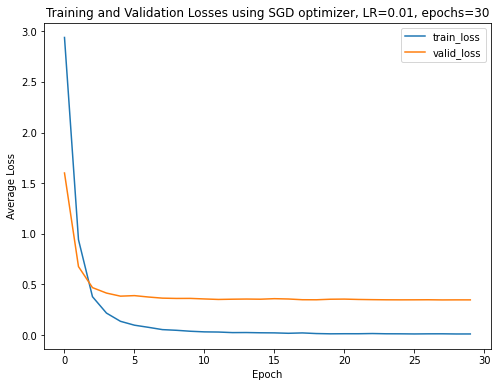

In [ ]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(val_dataloader):
#for images, labels in val_dataloader:
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass in order to get logits/output
  outputs = net(images)

  # Get predictions from the maximum value
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(val_dataset))

print('Validation Accuracy performed on the best model: {}'.format(accuracy))


# History is a Dataframe
history = pd.DataFrame( history, columns=['train_loss', 'valid_loss'])

# Plot train_loss vs valid_loss
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
  plt.plot(history[c], label=c)

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title(f'Training and Validation Losses using SGD optimizer, LR={LR}, epochs={NUM_EPOCHS}')

from torchsummary import summary
summary(
        net, input_size=(3, 224, 224), batch_size=BATCH_SIZE, device='cuda')

**Test**

In [ ]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 23/23 [00:17<00:00,  1.32it/s]

Test Accuracy: 0.9014863463532665
